# 🧾 Cyber Threat Data Cleaning & Exploration

In [51]:
import pandas as pd
import numpy as np

# ---  Load the dataset ---
file_path = '/home/project/Documents/Smart Grid Intrusion Detection Dataset.csv' 
df = pd.read_csv(file_path)

# --- Initial overview ---
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# --- Standardize column names ---
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("\nCleaned column names:", df.columns.tolist())

# --- Handle missing values ---
missing_counts = df.isnull().sum()
print("\nMissing values before cleaning:\n", missing_counts[missing_counts > 0])

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing critical fields (e.g., timestamp or attack_type)
critical_cols = ['timestamp', 'attack_type']
for col in critical_cols:
    if col in df.columns:
        df = df.dropna(subset=[col])

# Fill numeric columns with median values
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill remaining missing categorical columns with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# --- Convert timestamp column ---
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])

# --- Final check ---
print("\nAfter cleaning:")
print(df.info())
print("\nRemaining missing values:")
print(df.isnull().sum().sum())

print(f"\nFinal dataset shape: {df.shape}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Timestamp       1000 non-null   object
 1   Source_IP       1000 non-null   object
 2   Destination_IP  1000 non-null   object
 3   Port            1000 non-null   int64 
 4   Protocol        1000 non-null   object
 5   Packet_Size     1000 non-null   int64 
 6   Attack_Type     1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB
None

First 5 rows:
       Timestamp    Source_IP Destination_IP  Port Protocol  Packet_Size  \
0  1/1/2023 0:00   172.16.0.3     10.0.0.101  8002      UDP          783   
1  1/1/2023 1:00  192.168.1.4   172.16.0.102  4127      TCP         1201   
2  1/1/2023 2:00  192.168.1.1  192.168.1.100  1361      UDP          543   
3  1/1/2023 3:00   172.16.0.3  192.168.1.100  8427      UDP           85   
4  1/1/2023 4:00   172.16.0.3 

In [32]:
#Convert Timestamp and Extract Temporal Features

import pandas as pd
import numpy as np

# --- Step 1: Ensure Timestamp is in datetime format ---
if 'timestamp' not in df.columns:
    raise KeyError("The dataset does not contain a 'timestamp' column. Please check column names.")

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).reset_index(drop=True)

# --- Step 2: Extract temporal components ---
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()

# --- Step 3: Define time segments based on hour ---
def get_time_segment(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_segment'] = df['hour'].apply(get_time_segment)

# --- Step 4: Create is_weekend flag ---
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# --- Step 5: Verify new features ---
print("Temporal Features Extracted Successfully!")
print(df[['timestamp', 'hour', 'day', 'weekday', 'time_segment', 'is_weekend']].head())


Temporal Features Extracted Successfully!
            timestamp  hour  day weekday time_segment  is_weekend
0 2023-01-01 00:00:00     0    1  Sunday        Night           1
1 2023-01-01 01:00:00     1    1  Sunday        Night           1
2 2023-01-01 02:00:00     2    1  Sunday        Night           1
3 2023-01-01 03:00:00     3    1  Sunday        Night           1
4 2023-01-01 04:00:00     4    1  Sunday        Night           1


In [34]:
#Create Structured Dataset with Temporal Features

import pandas as pd
import numpy as np

# ---  Convert timestamp safely ---
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).reset_index(drop=True)

# --- Step 3: Extract temporal features ---
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()

def get_time_segment(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_segment'] = df['hour'].apply(get_time_segment)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# ---  Structured output ---
structured_df = df[['timestamp', 'source_ip', 'destination_ip', 'port', 'protocol',
                    'packet_size', 'attack_type', 'hour', 'day', 'weekday',
                    'time_segment', 'is_weekend']]

# ---  Display and save ---
print("Structured dataset with temporal features created successfully!\n")
print(structured_df.head(10))
print("\nDataset shape:", structured_df.shape)

# save to new CSV
structured_df.to_csv("SmartGrid_Structured_TimeFeatures.csv", index=False)
print("\nSaved structured dataset as 'SmartGrid_Structured_TimeFeatures.csv'")


Structured dataset with temporal features created successfully!

            timestamp    source_ip destination_ip  port protocol  packet_size  \
0 2023-01-01 00:00:00   172.16.0.3     10.0.0.101  8002      UDP          783   
1 2023-01-01 01:00:00  192.168.1.4   172.16.0.102  4127      TCP         1201   
2 2023-01-01 02:00:00  192.168.1.1  192.168.1.100  1361      UDP          543   
3 2023-01-01 03:00:00   172.16.0.3  192.168.1.100  8427      UDP           85   
4 2023-01-01 04:00:00   172.16.0.3  192.168.1.100   358      UDP         1436   
5 2023-01-01 05:00:00  192.168.1.4  192.168.1.100  5915      TCP          746   
6 2023-01-01 06:00:00  192.168.1.1  192.168.1.103  2728     ICMP          969   
7 2023-01-01 07:00:00  192.168.1.1  192.168.1.100  1770      UDP          383   
8 2023-01-01 08:00:00   172.16.0.3  192.168.1.103  5624      TCP          189   
9 2023-01-01 09:00:00     10.0.0.2  192.168.1.103  2441      TCP          340   

      attack_type  hour  day weekday time_s

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


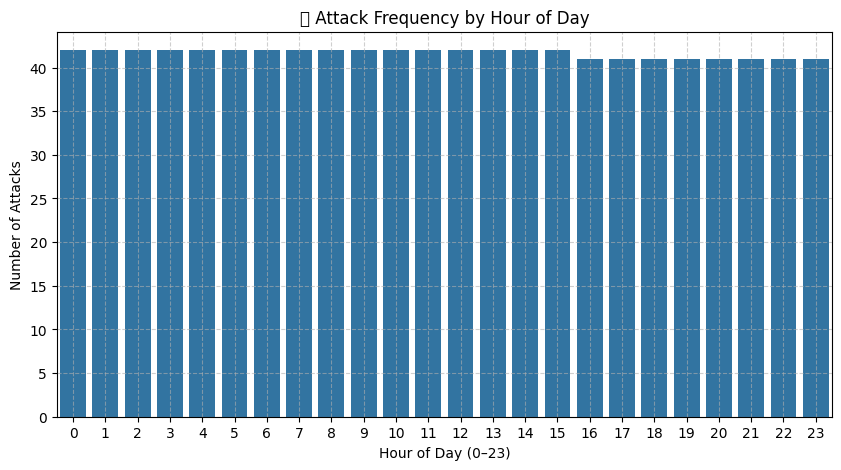

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


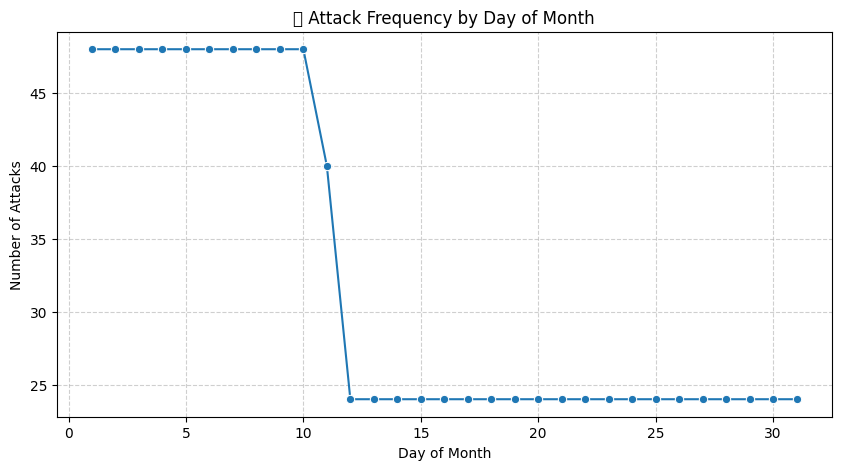

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


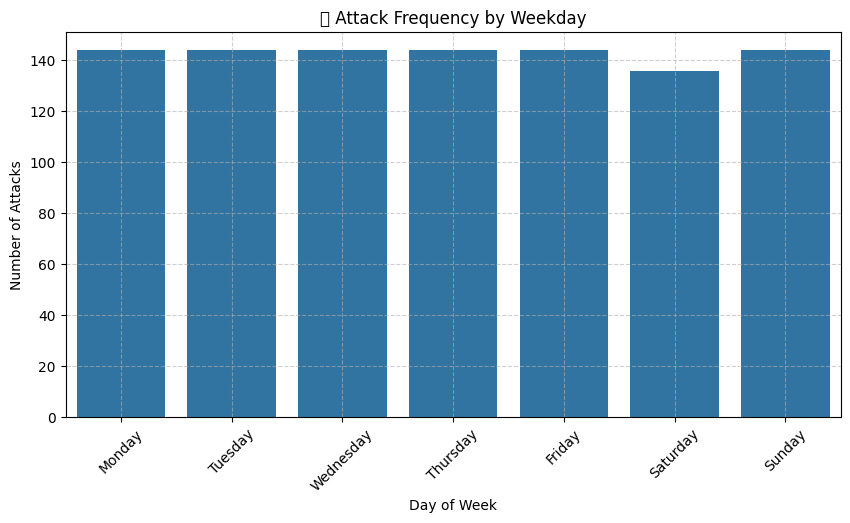

✅ Attack Frequency Summary:

Top 3 Hours with Most Attacks:
     Hour  Attack_Count
0      0            42
9      9            42
15    15            42

Top 3 Days with Most Attacks:
    Day  Attack_Count
0    1            48
1    2            48
2    3            48

Top 3 Weekdays with Most Attacks:
      Weekday  Attack_Count
1     Monday           144
5    Tuesday           144
6  Wednesday           144


In [36]:
#Attack Frequency Analysis by Hour / Day / Weekday

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure your structured dataset is loaded
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')

# --- Step 1: Verify data types ---
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['weekday'] = df['weekday'].astype(str)

# --- Step 2: Attack frequency by HOUR ---
hourly_counts = df.groupby('hour')['attack_type'].count().reset_index()
hourly_counts.columns = ['Hour', 'Attack_Count']

plt.figure(figsize=(10,5))
sns.barplot(x='Hour', y='Attack_Count', data=hourly_counts)
plt.title('🔍 Attack Frequency by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Attacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Step 3: Attack frequency by DAY ---
daily_counts = df.groupby('day')['attack_type'].count().reset_index()
daily_counts.columns = ['Day', 'Attack_Count']

plt.figure(figsize=(10,5))
sns.lineplot(x='Day', y='Attack_Count', data=daily_counts, marker='o')
plt.title('📆 Attack Frequency by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Attacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Step 4: Attack frequency by WEEKDAY ---
weekday_counts = df.groupby('weekday')['attack_type'].count().reset_index()
weekday_counts.columns = ['Weekday', 'Attack_Count']

# Optional: Reorder weekdays for better visualization
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts['Weekday'] = pd.Categorical(weekday_counts['Weekday'], categories=weekday_order, ordered=True)
weekday_counts = weekday_counts.sort_values('Weekday')

plt.figure(figsize=(10,5))
sns.barplot(x='Weekday', y='Attack_Count', data=weekday_counts)
plt.title('📅 Attack Frequency by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Step 5: Summary statistics ---
print("✅ Attack Frequency Summary:")
print("\nTop 3 Hours with Most Attacks:\n", hourly_counts.sort_values('Attack_Count', ascending=False).head(3))
print("\nTop 3 Days with Most Attacks:\n", daily_counts.sort_values('Attack_Count', ascending=False).head(3))
print("\nTop 3 Weekdays with Most Attacks:\n", weekday_counts.sort_values('Attack_Count', ascending=False).head(3))


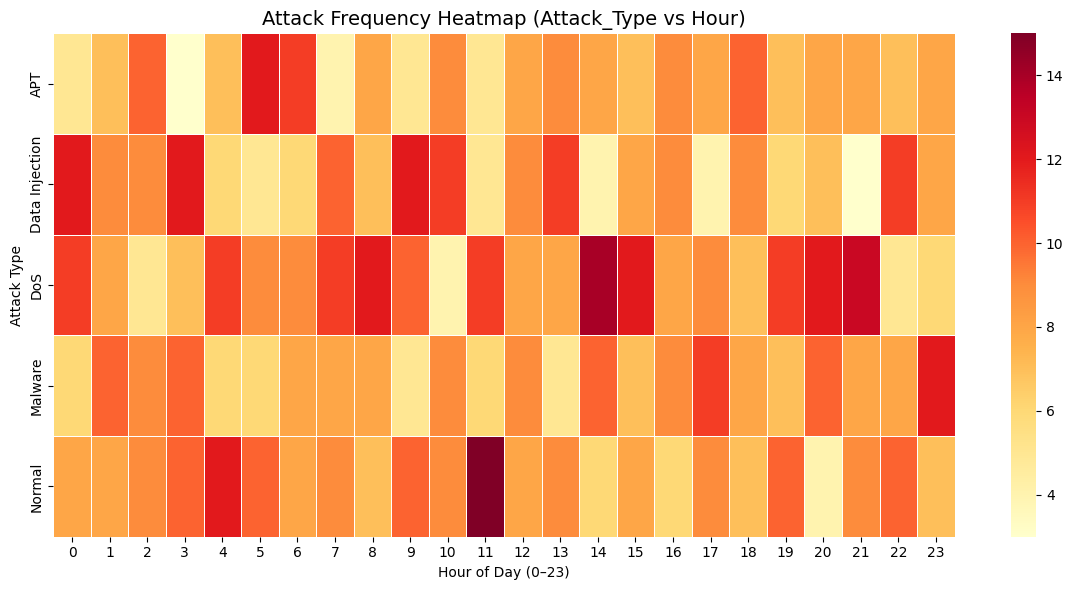

/tmp/ipykernel_4108/3274829131.py:38: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


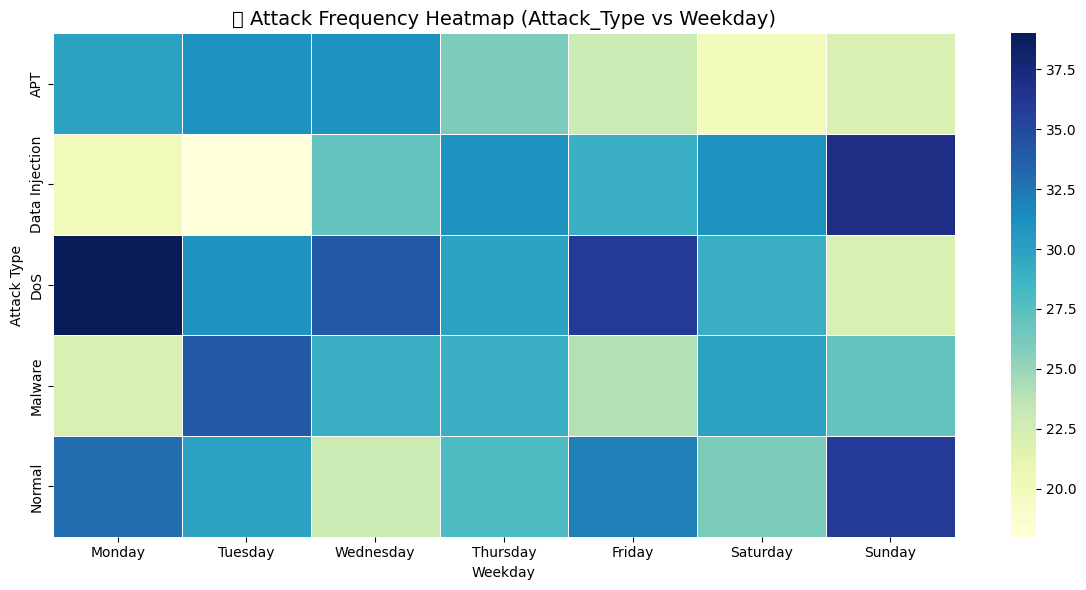

/tmp/ipykernel_4108/3274829131.py:48: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


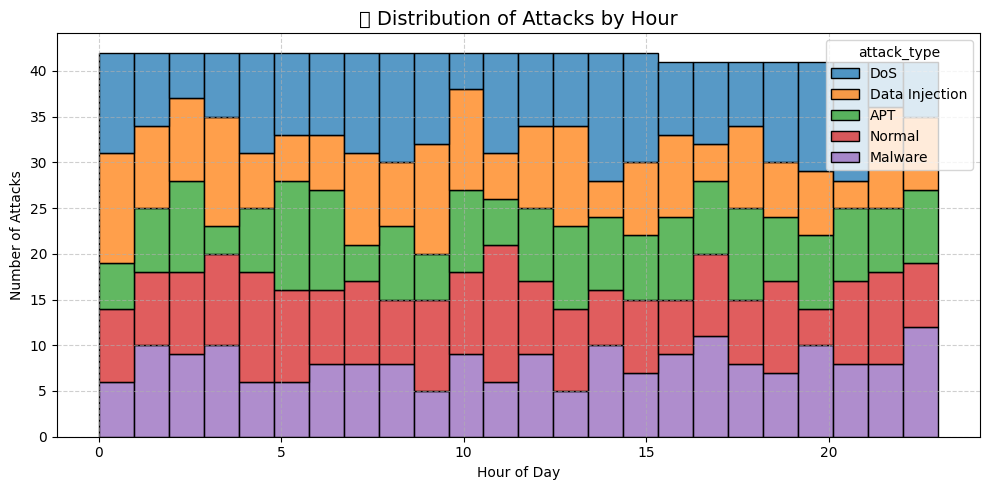

/tmp/ipykernel_4108/3274829131.py:58: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


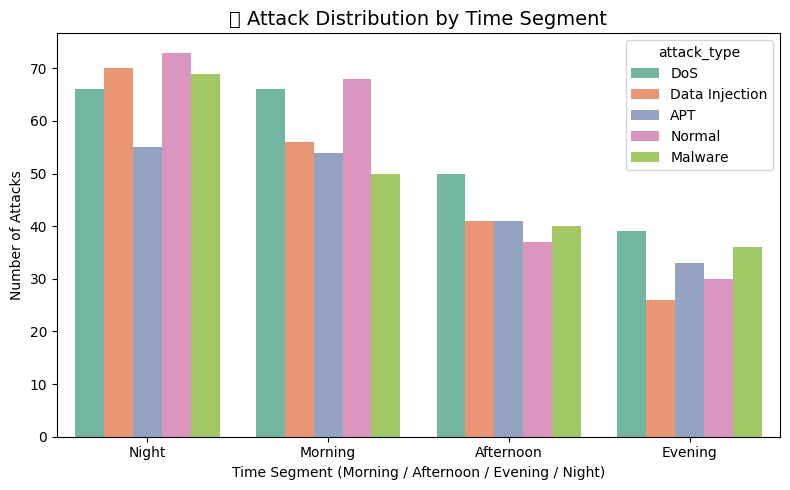

Visualizations created successfully!


In [54]:
#Heatmaps & Histogram for Temporal Attack Patterns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure your structured dataset is loaded
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')

# Ensure timestamp and hour are correct
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
if 'hour' not in df.columns:
    df['hour'] = df['timestamp'].dt.hour

# ---  Attack Frequency Heatmap (Attack_Type vs Hour) ---
plt.figure(figsize=(12,6))
heatmap_data = df.groupby(['attack_type', 'hour']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)
plt.title('Attack Frequency Heatmap (Attack_Type vs Hour)', fontsize=14)
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# --- Attack Frequency Heatmap (Attack_Type vs Weekday) ---
plt.figure(figsize=(12,6))
heatmap_data2 = df.groupby(['attack_type', 'weekday']).size().unstack(fill_value=0)

# Reorder weekdays for clarity
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data2 = heatmap_data2[weekday_order]

sns.heatmap(heatmap_data2, cmap='YlGnBu', linewidths=0.5)
plt.title('📅 Attack Frequency Heatmap (Attack_Type vs Weekday)', fontsize=14)
plt.xlabel('Weekday')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# ---  Histogram of Attacks by Hour ---
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='hour', hue='attack_type', multiple='stack', bins=24, palette='tab10')
plt.title('⏰ Distribution of Attacks by Hour', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Attacks')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Histogram of Attacks by Time Segment ---
if 'time_segment' in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='time_segment', hue='attack_type', palette='Set2')
    plt.title('🕒 Attack Distribution by Time Segment', fontsize=14)
    plt.xlabel('Time Segment (Morning / Afternoon / Evening / Night)')
    plt.ylabel('Number of Attacks')
    plt.tight_layout()
    plt.show()

# --- Summary ---
print("Visualizations created successfully!")

In [56]:
#Statistical Tests (Chi-square & ANOVA)

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway

# Ensure your structured dataset is loaded
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')

# ---  Ensure proper datetime & temporal columns ---
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
if 'hour' not in df.columns:
    df['hour'] = df['timestamp'].dt.hour
if 'weekday' not in df.columns:
    df['weekday'] = df['timestamp'].dt.day_name()

# --- Chi-Square Tests for categorical relationships ---

def chi_square_test(var):
    contingency = pd.crosstab(df[var], df['attack_type'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\n🧩 Chi-Square Test — Attack_Type vs {var}")
    print(f"Chi2 statistic = {chi2:.3f}, p-value = {p:.6f}, dof = {dof}")
    if p < 0.05:
        print("✅ Significant relationship: Attack occurrence depends on", var)
    else:
        print("❌ No significant relationship: Attack occurrence independent of", var)

# Apply to weekday and time_segment
if 'weekday' in df.columns:
    chi_square_test('weekday')

if 'time_segment' in df.columns:
    chi_square_test('time_segment')


# ---  ANOVA Tests for numeric relationships ---

def anova_test(var):
    groups = [df[df['attack_type'] == att][var].dropna() for att in df['attack_type'].unique()]
    if all(g.nunique() > 1 for g in groups):  # Avoid constant group errors
        f_stat, p_val = f_oneway(*groups)
        print(f"\n📊 ANOVA Test — Attack_Type vs {var}")
        print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.6f}")
        if p_val < 0.05:
            print("Significant difference: Attack occurrence varies by", var)
        else:
            print("No significant difference: Attack occurrence not influenced by", var)
    else:
        print(f"\nSkipping ANOVA for {var} — one or more groups have constant values.")

# Apply to hour and day
anova_test('hour')
if 'day' in df.columns:
    anova_test('day')


🧩 Chi-Square Test — Attack_Type vs weekday
Chi2 statistic = 27.069, p-value = 0.301232, dof = 24
❌ No significant relationship: Attack occurrence independent of weekday

🧩 Chi-Square Test — Attack_Type vs time_segment
Chi2 statistic = 8.078, p-value = 0.778985, dof = 12
❌ No significant relationship: Attack occurrence independent of time_segment

📊 ANOVA Test — Attack_Type vs hour
F-statistic = 0.938, p-value = 0.440975
No significant difference: Attack occurrence not influenced by hour

📊 ANOVA Test — Attack_Type vs day
F-statistic = 0.690, p-value = 0.598749
No significant difference: Attack occurrence not influenced by day



📊 ANOVA Test — Attack_Type vs hour
F-statistic = 0.938, p-value = 0.440975
No significant difference: Attack occurrence not influenced by hour

📊 ANOVA Test — Attack_Type vs day
F-statistic = 0.690, p-value = 0.598749
No significant difference: Attack occurrence not influenced by day


/tmp/ipykernel_4108/1604922399.py:31: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


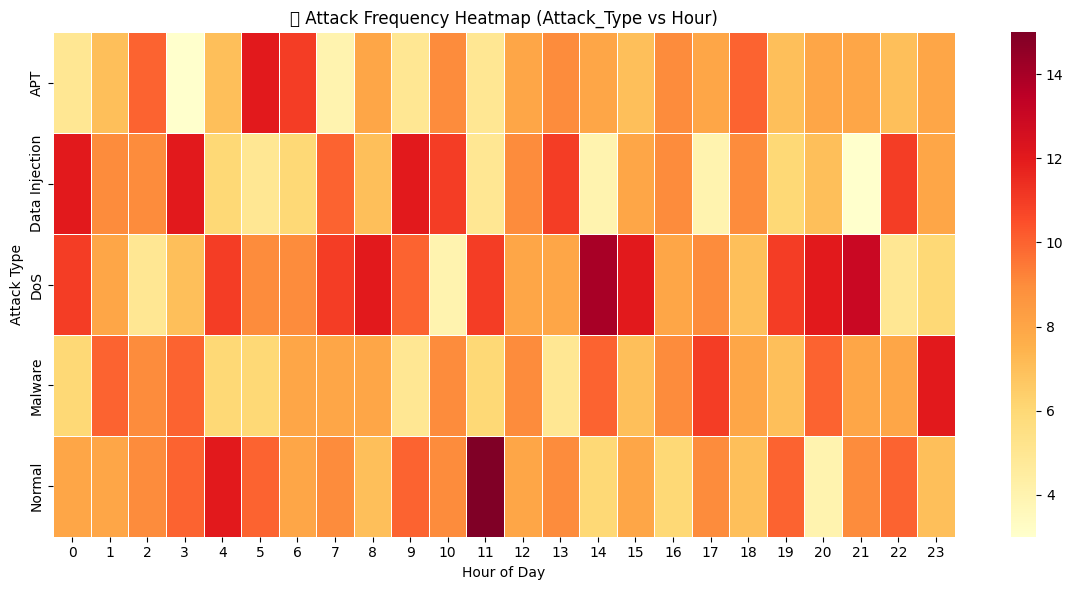

/tmp/ipykernel_4108/1604922399.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='attack_type', y='hour', data=df, palette='Set3')
/tmp/ipykernel_4108/1604922399.py:41: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


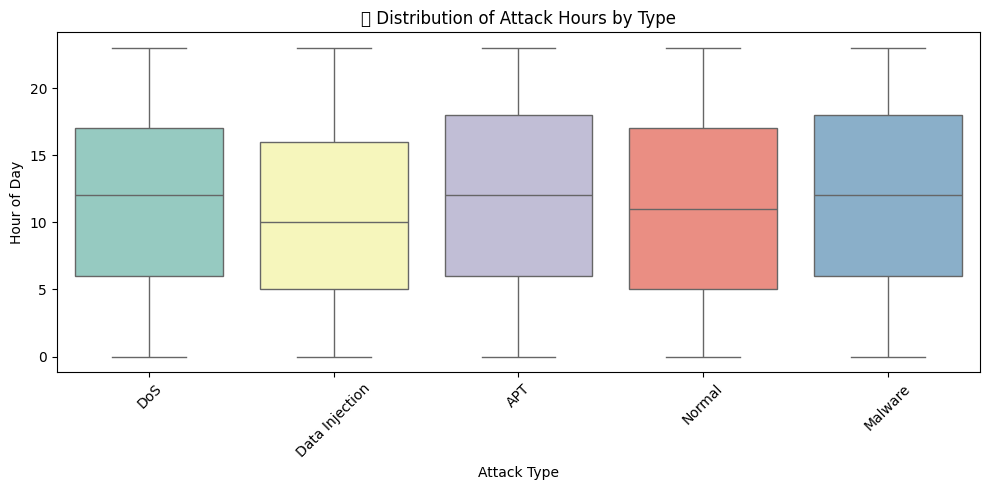

/tmp/ipykernel_4108/1604922399.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='attack_type', y=df['timestamp'].dt.dayofweek, data=df, palette='Set2')
/tmp/ipykernel_4108/1604922399.py:51: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


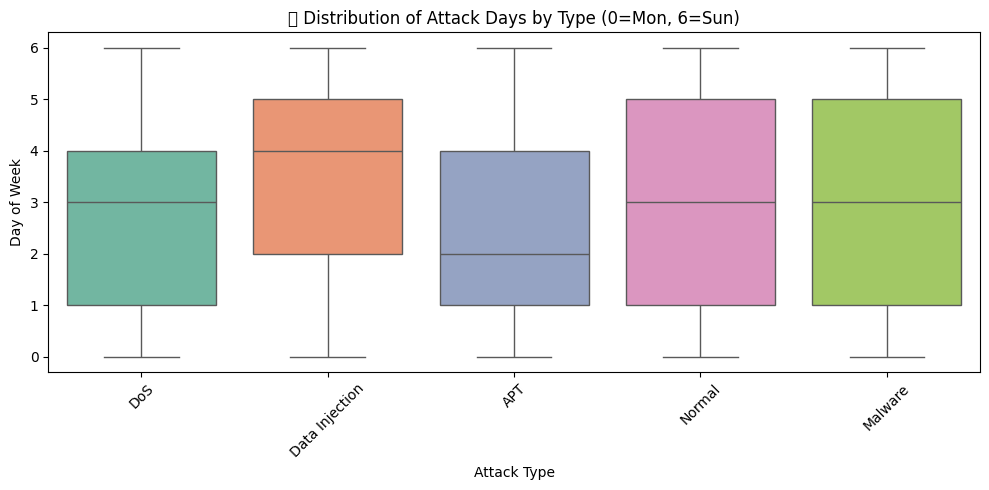

🧩 Chi-Square Test — Attack_Type vs Weekday
Chi2 = 27.069, p-value = 0.301232, dof = 24
❌ Not significant: Attack occurrence is independent of weekday.

🧩 Chi-Square Test — Attack_Type vs Time Segment
Chi2 = 8.078, p-value = 0.778985, dof = 12
❌ Not significant: Attack occurrence is independent of time segment.

📊 ANOVA Test — Attack_Type vs Hour
F-statistic = 0.938, p-value = 0.440975
❌ Not significant: Attack frequency does not vary by hour.

📊 ANOVA Test — Attack_Type vs Day
F-statistic = 0.690, p-value = 0.598749
❌ Not significant: Attack frequency does not vary by day.



In [57]:
#Visual + Statistical Evidence of Temporal Attack Patterns

# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway

# Ensure your structured dataset is loaded
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')

# --- Step 2: Ensure time columns are valid ---
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
if 'hour' not in df.columns:
    df['hour'] = df['timestamp'].dt.hour
if 'weekday' not in df.columns:
    df['weekday'] = df['timestamp'].dt.day_name()

# ---------------------------------------------------------
# 📊 VISUAL EVIDENCE
# ---------------------------------------------------------

# --- Attack Frequency Heatmap (Attack_Type vs Hour) ---
plt.figure(figsize=(12,6))
heatmap_data = df.groupby(['attack_type', 'hour']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)
plt.title('🔥 Attack Frequency Heatmap (Attack_Type vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# --- Boxplot: Attack_Type vs Hour ---
plt.figure(figsize=(10,5))
sns.boxplot(x='attack_type', y='hour', data=df, palette='Set3')
plt.title('⏰ Distribution of Attack Hours by Type')
plt.xlabel('Attack Type')
plt.ylabel('Hour of Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Boxplot: Attack_Type vs Day of Week ---
plt.figure(figsize=(10,5))
sns.boxplot(x='attack_type', y=df['timestamp'].dt.dayofweek, data=df, palette='Set2')
plt.title('📅 Distribution of Attack Days by Type (0=Mon, 6=Sun)')
plt.xlabel('Attack Type')
plt.ylabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Chi-square test: Attack_Type vs Weekday ---
contingency_weekday = pd.crosstab(df['attack_type'], df['weekday'])
chi2, p, dof, expected = chi2_contingency(contingency_weekday)
print("🧩 Chi-Square Test — Attack_Type vs Weekday")
print(f"Chi2 = {chi2:.3f}, p-value = {p:.6f}, dof = {dof}")
if p < 0.05:
    print("✅ Significant: Attack occurrence depends on weekday.\n")
else:
    print("❌ Not significant: Attack occurrence is independent of weekday.\n")

# --- Chi-square test: Attack_Type vs Time Segment ---
if 'time_segment' in df.columns:
    contingency_segment = pd.crosstab(df['attack_type'], df['time_segment'])
    chi2, p, dof, expected = chi2_contingency(contingency_segment)
    print("🧩 Chi-Square Test — Attack_Type vs Time Segment")
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.6f}, dof = {dof}")
    if p < 0.05:
        print("✅ Significant: Attack occurrence depends on time segment.\n")
    else:
        print("❌ Not significant: Attack occurrence is independent of time segment.\n")

# --- ANOVA test: Attack_Type vs Hour ---
groups = [df[df['attack_type']==att]['hour'].dropna() for att in df['attack_type'].unique()]
if all(g.nunique() > 1 for g in groups):
    f_stat, p_val = f_oneway(*groups)
    print("📊 ANOVA Test — Attack_Type vs Hour")
    print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.6f}")
    if p_val < 0.05:
        print("✅ Significant: Attack frequency varies by hour.\n")
    else:
        print("❌ Not significant: Attack frequency does not vary by hour.\n")
else:
    print("⚠️ ANOVA skipped — some groups have constant hour values.\n")

# --- ANOVA test: Attack_Type vs Day ---
if 'day' in df.columns:
    groups_day = [df[df['attack_type']==att]['day'].dropna() for att in df['attack_type'].unique()]
    if all(g.nunique() > 1 for g in groups_day):
        f_stat, p_val = f_oneway(*groups_day)
        print("📊 ANOVA Test — Attack_Type vs Day")
        print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.6f}")
        if p_val < 0.05:
            print("✅ Significant: Attack frequency varies by day.\n")
        else:
            print("❌ Not significant: Attack frequency does not vary by day.\n")

/home/project/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:28:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ranked List of Most Influential Temporal Features:

            Feature  Importance
0        is_weekend    0.223038
1               day    0.215921
2              hour    0.207533
3       weekday_enc    0.183418
4  time_segment_enc    0.170090


/tmp/ipykernel_4108/3645953868.py:72: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


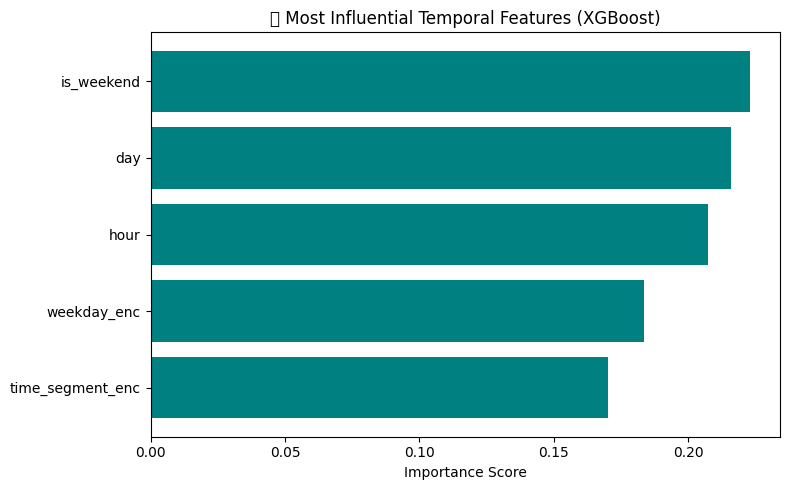

In [60]:
#Ranked Temporal Feature Importance (Final Output)

import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Load structured dataset ---
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).reset_index(drop=True)

# --- Ensure all temporal features exist ---
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Encode categorical features
le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

le_segment = LabelEncoder()
if 'time_segment' in df.columns:
    df['time_segment_enc'] = le_segment.fit_transform(df['time_segment'])
else:
    df['time_segment_enc'] = 0

# Encode attack_type (target)
le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

# --- Define features & target ---
X = df[['hour', 'day', 'weekday_enc', 'time_segment_enc', 'is_weekend']]
y = df['attack_label']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Train model ---
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)

# --- Compute and rank feature importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# --- Display ranked list ---
print("✅ Ranked List of Most Influential Temporal Features:\n")
print(importance_df)

# --- Optional: visualize ---
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('🔍 Most Influential Temporal Features (XGBoost)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



/home/project/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:28:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ XGBoost Model Accuracy: 21.00%

Classification Report:
                precision    recall  f1-score   support

           APT       0.27      0.27      0.27        55
Data Injection       0.21      0.22      0.22        58
           DoS       0.20      0.18      0.19        66
       Malware       0.13      0.12      0.13        59
        Normal       0.23      0.26      0.24        62

      accuracy                           0.21       300
     macro avg       0.21      0.21      0.21       300
  weighted avg       0.21      0.21      0.21       300



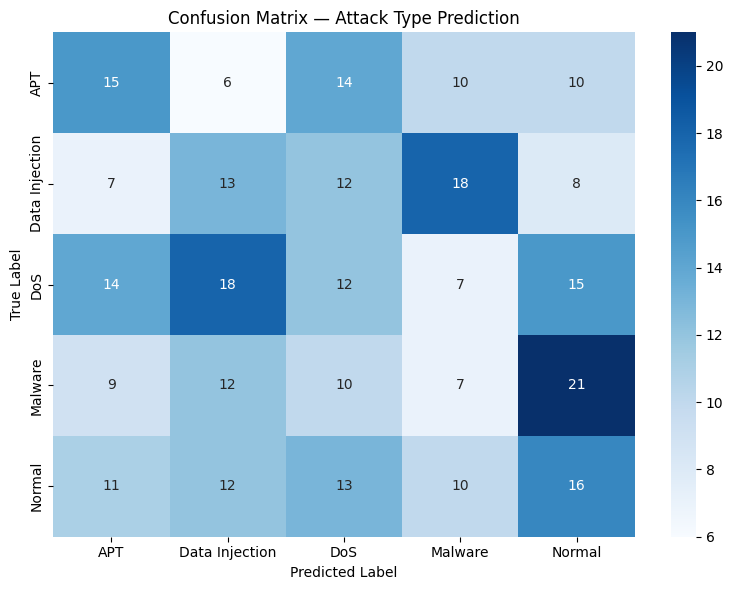


💾 Model saved as 'XGBoost_Temporal_Attack_Model.pkl'


In [61]:
#Build and Train XGBoost Model

# --- Imports ---
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load structured dataset ---
df = pd.read_csv('/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).reset_index(drop=True)

# --- Step 2: Extract/verify temporal features ---
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Create time segments
def get_segment(h):
    if 5 <= h < 12: return "Morning"
    elif 12 <= h < 17: return "Afternoon"
    elif 17 <= h < 21: return "Evening"
    else: return "Night"
df['time_segment'] = df['hour'].apply(get_segment)

# --- Step 3: Encode categorical features ---
le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

le_segment = LabelEncoder()
df['time_segment_enc'] = le_segment.fit_transform(df['time_segment'])

le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

# --- Step 4: Define features and target ---
selected_features = ['hour', 'weekday_enc', 'day', 'time_segment_enc', 'is_weekend']
X = df[selected_features]
y = df['attack_label']

# --- Step 5: Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 6: Build and train XGBoost model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)

# --- Step 7: Predict attack type on test data ---
y_pred = xgb_model.predict(X_test)

# --- Step 8: Evaluate performance ---
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ XGBoost Model Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

# --- Step 9: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_attack.classes_,
            yticklabels=le_attack.classes_)
plt.title('Confusion Matrix — Attack Type Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- Step 10: Save model for future predictions ---
import joblib
joblib.dump(xgb_model, "XGBoost_Temporal_Attack_Model.pkl")
print("\n💾 Model saved as 'XGBoost_Temporal_Attack_Model.pkl'")


/home/project/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:39:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Time-Aware XGBoost Model Accuracy: 19.50%

Classification Report:
                precision    recall  f1-score   support

           APT       0.07      0.05      0.06        42
Data Injection       0.21      0.31      0.25        32
           DoS       0.29      0.20      0.24        49
       Malware       0.14      0.19      0.16        37
        Normal       0.25      0.25      0.25        40

      accuracy                           0.20       200
     macro avg       0.19      0.20      0.19       200
  weighted avg       0.19      0.20      0.19       200



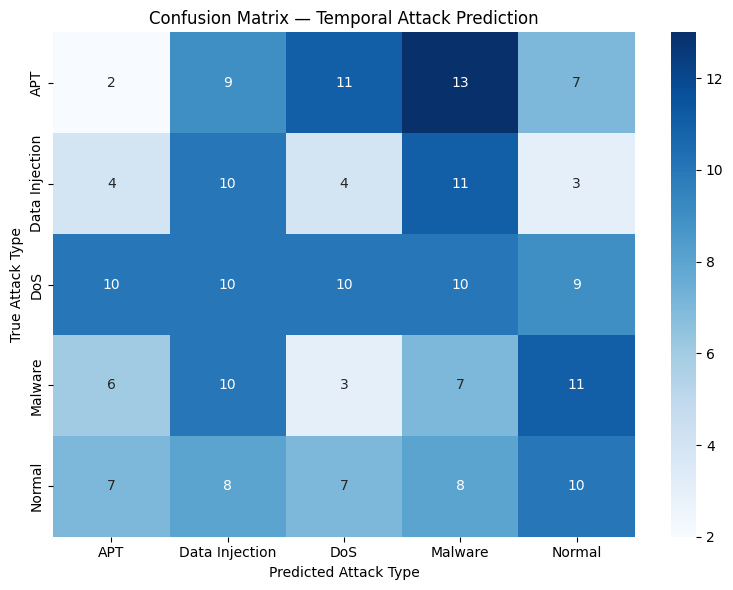


💾 Model saved as 'XGBoost_TimeAware_Attack_Model.pkl'


In [62]:
#Time-Aware XGBoost Prediction Model

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- Step 1: Load and prepare dataset ---
df = pd.read_csv("/home/project/Documents/SmartGrid_Structured_TimeFeatures.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)

# --- Step 2: Extract temporal features ---
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

def get_segment(h):
    if 5 <= h < 12: return "Morning"
    elif 12 <= h < 17: return "Afternoon"
    elif 17 <= h < 21: return "Evening"
    else: return "Night"
df['time_segment'] = df['hour'].apply(get_segment)

# --- Step 3: Encode categorical features ---
le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

le_segment = LabelEncoder()
df['time_segment_enc'] = le_segment.fit_transform(df['time_segment'])

le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

# --- Step 4: Create "lag" features to capture recent time patterns ---
# Each record looks back at previous n=3 attacks to learn sequential patterns
n_lags = 3
for lag in range(1, n_lags + 1):
    df[f'prev_attack_{lag}'] = df['attack_label'].shift(lag)
    df[f'prev_hour_{lag}'] = df['hour'].shift(lag)

# Drop missing rows caused by shifting
df = df.dropna().reset_index(drop=True)

# --- Step 5: Define features and target ---
features = [
    'hour', 'day', 'weekday_enc', 'time_segment_enc', 'is_weekend',
    'prev_attack_1', 'prev_attack_2', 'prev_attack_3',
    'prev_hour_1', 'prev_hour_2', 'prev_hour_3'
]
X = df[features]
y = df['attack_label']

# --- Step 6: Train/test split (chronological) ---
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- Step 7: Train XGBoost model ---
xgb_time = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_time.fit(X_train, y_train)

# --- Step 8: Predict on future time steps ---
y_pred = xgb_time.predict(X_test)

# --- Step 9: Evaluate model ---
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Time-Aware XGBoost Model Accuracy: {acc:.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

# --- Step 10: Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_attack.classes_,
            yticklabels=le_attack.classes_)
plt.title("Confusion Matrix — Temporal Attack Prediction")
plt.xlabel("Predicted Attack Type")
plt.ylabel("True Attack Type")
plt.tight_layout()
plt.show()

# --- Step 11: Save trained model ---
joblib.dump(xgb_time, "XGBoost_TimeAware_Attack_Model.pkl")
print("\n💾 Model saved as 'XGBoost_TimeAware_Attack_Model.pkl'")


✅ **Model Evaluation Results**
Accuracy:  19.50%
Precision: 19.50%
Recall:    19.50%
F1-score:  19.08%

📋 Classification Report:
                precision    recall  f1-score   support

           APT       0.07      0.05      0.06        42
Data Injection       0.21      0.31      0.25        32
           DoS       0.29      0.20      0.24        49
       Malware       0.14      0.19      0.16        37
        Normal       0.25      0.25      0.25        40

      accuracy                           0.20       200
     macro avg       0.19      0.20      0.19       200
  weighted avg       0.19      0.20      0.19       200



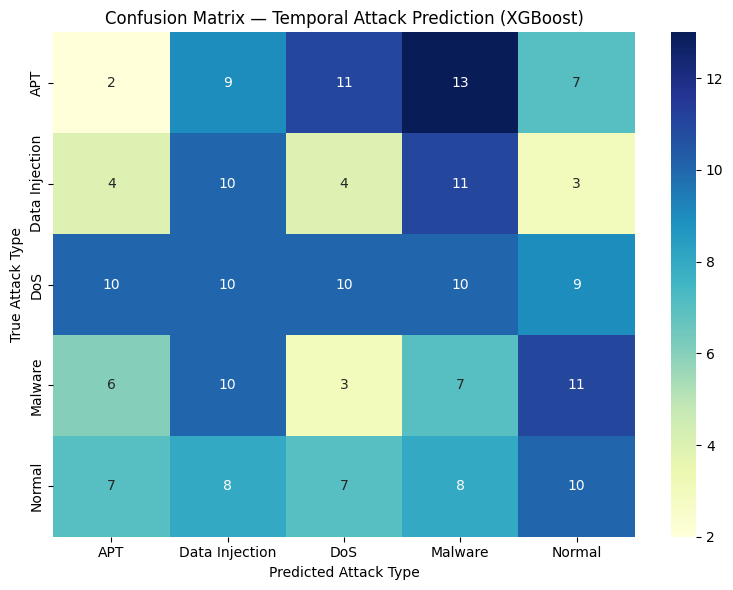

In [63]:
#Model Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# --- Step 1: Load model (optional if already in memory) ---
xgb_time = joblib.load("XGBoost_TimeAware_Attack_Model.pkl")

# --- Step 2: Predict on test set ---
y_pred = xgb_time.predict(X_test)

# --- Step 3: Evaluate Metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("✅ **Model Evaluation Results**")
print(f"Accuracy:  {acc:.2%}")
print(f"Precision: {prec:.2%}")
print(f"Recall:    {rec:.2%}")
print(f"F1-score:  {f1:.2%}")

# --- Step 4: Detailed Report ---
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

# --- Step 5: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le_attack.classes_,
            yticklabels=le_attack.classes_)
plt.title("Confusion Matrix — Temporal Attack Prediction (XGBoost)")
plt.xlabel("Predicted Attack Type")
plt.ylabel("True Attack Type")
plt.tight_layout()
plt.show()


/home/project/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 0.19

Classification Report:
                precision    recall  f1-score   support

           Apt       0.21      0.24      0.22        55
Data Injection       0.19      0.17      0.18        58
           Dos       0.16      0.17      0.16        66
       Malware       0.17      0.14      0.15        59
        Normal       0.20      0.23      0.21        62

      accuracy                           0.19       300
     macro avg       0.19      0.19      0.19       300
  weighted avg       0.19      0.19      0.19       300


Ranked Feature Importance:
       Feature  Importance
0         hour    0.210380
1   is_weekend    0.186890
2          day    0.166303
3   weekofyear    0.153520
4  weekday_enc    0.142755
5        month    0.140151


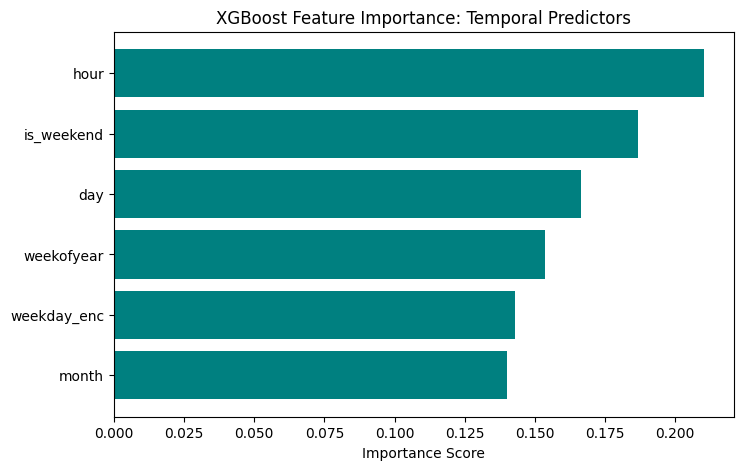

In [23]:
# --- Step 1: Extract temporal features ---

df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

 

# --- Step 2: Encode categorical features ---

le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday']) 

le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

 

# --- Step 3: Define features and target ---

X = df[['hour', 'weekday_enc', 'day', 'month', 'weekofyear', 'is_weekend']]
y = df['attack_label']

 

# --- Step 4: Train-test split ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 5: Train XGBoost model ---

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train) 

# --- Step 6: Evaluate performance ---

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

 

# --- Step 7: Feature Importance ---

importances = xgb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nRanked Feature Importance:")
print(importance_df)

 

# --- Step 8: Plot ---

plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('XGBoost Feature Importance: Temporal Predictors')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

/home/project/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model Accuracy: 0.190
Precision: 0.196
Recall: 0.190
F1-Score: 0.188

Detailed Report:
                precision    recall  f1-score   support

           Apt       0.21      0.12      0.15        42
Data Injection       0.14      0.22      0.17        32
           Dos       0.21      0.16      0.18        49
       Malware       0.16      0.19      0.17        37
        Normal       0.24      0.28      0.26        40

      accuracy                           0.19       200
     macro avg       0.19      0.19      0.19       200
  weighted avg       0.20      0.19      0.19       200



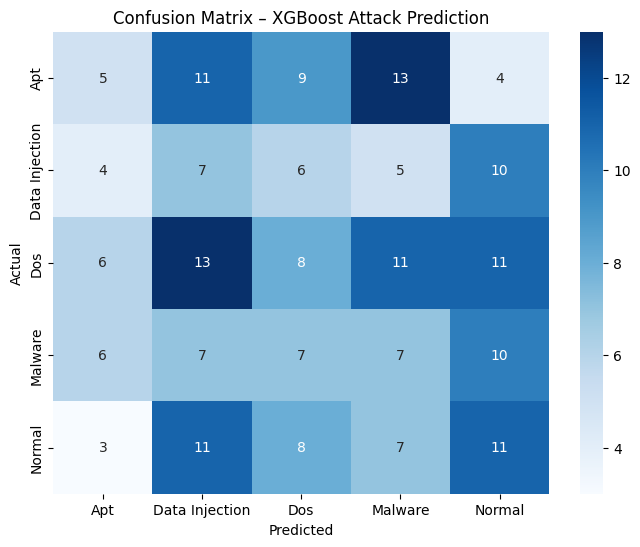

/tmp/ipykernel_4108/518588514.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


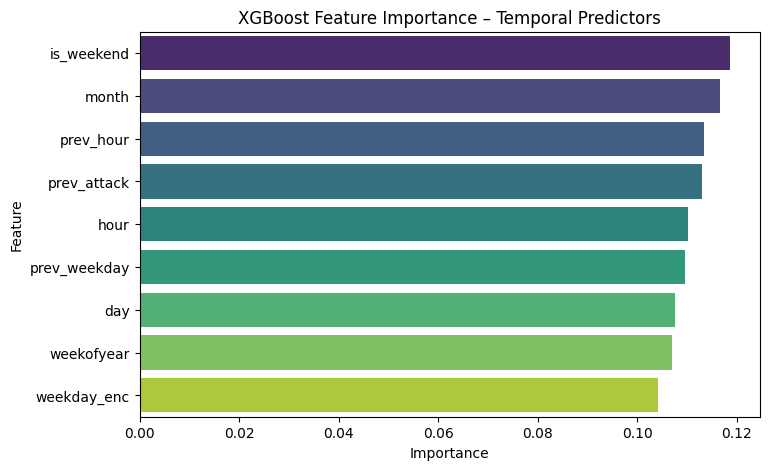


📊 Ranked Feature Importance:
        Feature  Importance
5    is_weekend    0.118639
3         month    0.116670
7     prev_hour    0.113421
6   prev_attack    0.113017
0          hour    0.110093
8  prev_weekday    0.109504
2           day    0.107543
4    weekofyear    0.107024
1   weekday_enc    0.104089

🚨 Next probable attack type: Malware


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp safely
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'attack_type']).reset_index(drop=True)

# --- Step 2: Extract temporal features ---
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# --- Step 3: Encode categorical features ---
le_attack = LabelEncoder()
df['attack_label'] = le_attack.fit_transform(df['attack_type'])

le_weekday = LabelEncoder()
df['weekday_enc'] = le_weekday.fit_transform(df['weekday'])

# --- Step 4: Create lag features to capture temporal patterns ---
# These represent previous time step(s)
df['prev_attack'] = df['attack_label'].shift(1)
df['prev_hour'] = df['hour'].shift(1)
df['prev_weekday'] = df['weekday_enc'].shift(1)

# Drop rows with NaN created by shifting
df = df.dropna().reset_index(drop=True)

# --- Step 5: Define features and target ---
X = df[['hour', 'weekday_enc', 'day', 'month', 'weekofyear', 'is_weekend',
        'prev_attack', 'prev_hour', 'prev_weekday']]
y = df['attack_label']

# --- Step 6: Chronological Train-Test Split ---
split = int(0.8 * len(df))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# --- Step 7: Train XGBoost model ---
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)

# --- Step 8: Evaluate model ---
y_pred = xgb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Model Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

# --- Step 9: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_attack.classes_,
            yticklabels=le_attack.classes_)
plt.title("Confusion Matrix – XGBoost Attack Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Step 10: Feature Importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("XGBoost Feature Importance – Temporal Predictors")
plt.show()

print("\n📊 Ranked Feature Importance:")
print(importance_df)

# --- Step 11: Predict next probable attack type ---
# Use the most recent time window
latest_features = X.iloc[-1:].copy()
predicted_class = xgb_model.predict(latest_features)[0]
predicted_attack = le_attack.inverse_transform([predicted_class])[0]

print(f"\n🚨 Next probable attack type: {predicted_attack}")



📈 Model Evaluation Metrics
✅ Accuracy:  0.1900
🎯 Precision: 0.1961
📞 Recall:    0.1900
📊 F1-Score:  0.1881

Detailed Classification Report:
                precision    recall  f1-score   support

           Apt       0.21      0.12      0.15        42
Data Injection       0.14      0.22      0.17        32
           Dos       0.21      0.16      0.18        49
       Malware       0.16      0.19      0.17        37
        Normal       0.24      0.28      0.26        40

      accuracy                           0.19       200
     macro avg       0.19      0.19      0.19       200
  weighted avg       0.20      0.19      0.19       200



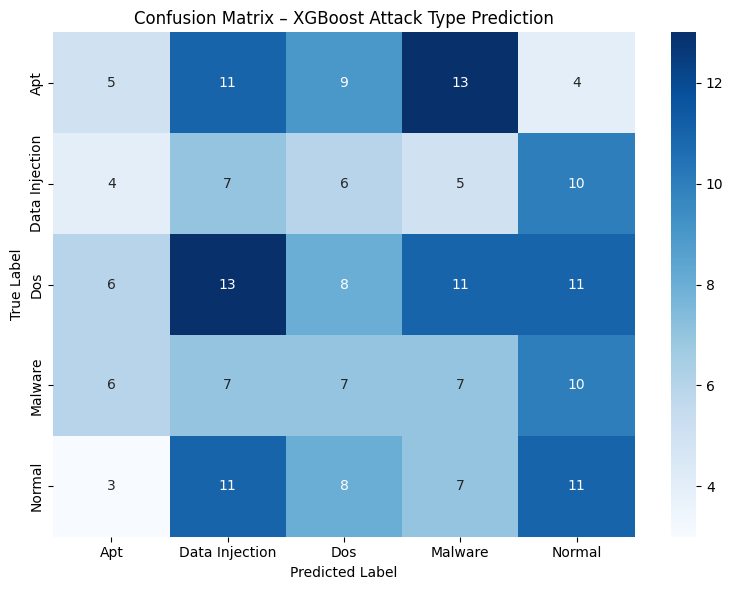

In [25]:
# --- Evaluation Metrics ---

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# --- Print results ---
print("📈 Model Evaluation Metrics")
print("="*40)
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📞 Recall:    {recall:.4f}")
print(f"📊 F1-Score:  {f1:.4f}")
print("="*40)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_attack.classes_,
            yticklabels=le_attack.classes_)
plt.title("Confusion Matrix – XGBoost Attack Type Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()